## Dog Breed App: Predicting Group type based on featureset
# Method : Random Forests

In [34]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline


In [35]:
# Loading data
file_path = Path("../sourcedata/akc_dog_breed_cln.csv")
dog_breed_val_df = pd.read_csv(file_path)
dog_breed_val_df.head()

,breed,description,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,...,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category,akc_breed,kaggle_breed,Img_Link,group_values
0,Affenpinscher,The Affen’s apish look has been described many...,"Confident, Famously Funny, Fearless",148,10,12,7,12,12,15,...,0.6,Regular Exercise,0.8,Easy Training,1.0,Outgoing,affenpinscher,affenpinscher,https://www.akc.org/wp-content/uploads/2017/11...,0
1,Afghan Hound,"The Afghan Hound is an ancient breed, his whol...","Dignified, Profoundly Loyal, Aristocratic",113,25,27,50,60,12,15,...,0.8,Energetic,0.2,May be Stubborn,0.2,Aloof/Wary,afghan_hound,afghan_hound,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,1
2,Airedale Terrier,The Airedale Terrier is the largest of all ter...,"Friendly, Clever, Courageous",60,21,23,44,50,11,14,...,0.6,Regular Exercise,1.0,Eager to Please,0.8,Friendly,airedale_terrier,airedale,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,2
3,Akita,"Akitas are burly, heavy-boned spitz-type dogs ...","Courageous, Dignified, Profoundly Loyal",47,24,28,70,130,10,13,...,0.8,Energetic,1.0,Eager to Please,0.6,Alert/Responsive,akita,NaN,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,3
4,Alaskan Malamute,The Alaskan Malamute stands 23 to 25 inches at...,"Affectionate, Loyal, Playful",58,23,25,75,85,10,14,...,0.8,Energetic,0.4,Independent,0.8,Friendly,alaskan_malamute,malamute,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,3


## Loading and Preprocessing AKC (American Kanine Corp) Dataset Encoded Data

In [36]:
dog_breed_val_df.columns

Index(['breed', 'description', 'temperament', 'popularity', 'min_height',
       'max_height', 'min_weight', 'max_weight', 'min_expectancy',
       'max_expectancy', 'group', 'grooming_frequency_value',
       'grooming_frequency_category', 'shedding_value', 'shedding_category',
       'energy_level_value', 'energy_level_category', 'trainability_value',
       'trainability_category', 'demeanor_value', 'demeanor_category',
       'akc_breed', 'kaggle_breed', 'Img_Link', 'group_values'],
      dtype='object')

In [37]:
# Check for negative values in the entire DataFrame
num_dog_breed_data_df = dog_breed_val_df.apply(pd.to_numeric, errors='ignore')
has_negatives = (num_dog_breed_data_df._get_numeric_data() < 0).any().any()

# If has_negatives is True, there are negative values; otherwise, there are no negative values
if has_negatives:
    print("The DataFrame contains negative values.")
else:
    print("The DataFrame does not contain negative values.")



The DataFrame does not contain negative values.


In [63]:
# Duplicating data
dog_breed_new_df = [dog_breed_val_df,dog_breed_val_df,dog_breed_val_df,dog_breed_val_df,dog_breed_val_df,dog_breed_val_df,dog_breed_val_df,dog_breed_val_df,dog_breed_val_df,dog_breed_val_df,dog_breed_val_df]
dog_breed_data_df = pd.concat(dog_breed_new_df)
dog_breed_data_df = dog_breed_data_df.sample(frac = 25,replace=True).reset_index(drop=True)
dog_breed_data_df.shape


(76175, 25)

In [64]:
# Define features set
# cat_col = ['grooming_frequency_category','shedding_category', 'energy_level_category', 'trainability_category', 'demeanor_category']
# val_col = ['grooming_frequency_value', 'shedding_value', 'energy_level_value', 'trainability_value', 'demeanor_value']

col_to_drop = ['breed','group','description','grooming_frequency_category','shedding_category',
                'energy_level_category', 'trainability_category', 'demeanor_category', 'temperament',
                'akc_breed', 'kaggle_breed', 'Img_Link']

X = dog_breed_data_df.copy()
X.drop(col_to_drop, axis=1, inplace=True)
X.head()

,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value,group_values
0,0,19,21,79,99,10,14,0.2,0.2,0.6,0.4,0.4,4
1,54,8,11,5,10,14,16,0.4,0.6,0.6,1.0,1.0,0
2,127,20,22,40,60,12,14,0.8,0.6,0.6,0.4,1.0,7
3,133,10,12,12,12,15,17,0.4,0.4,0.6,0.8,0.6,0
4,0,21,23,40,55,10,12,0.4,0.6,0.8,0.2,0.4,4


In [65]:

# Function to generate random float value between min_height and max_height
# Apply the function to all rows and assign to 'min_height' column
def generate_random_min_height(row):
    return np.random.uniform(row['min_height'], row['min_height']+(row['max_height']-row['min_height']) / 2)

def generate_random_max_height(row):
    return np.random.uniform(row['min_height']+(row['max_height']-row['min_height']) / 2,row['max_height'])

dog_breed_data_df['min_height'] = dog_breed_data_df.apply(generate_random_min_height, axis=1)
dog_breed_data_df['max_height'] = dog_breed_data_df.apply(generate_random_max_height, axis=1)


# Function to generate random float value between min_weight and max_weight
# Apply the function to all rows and assign to 'weight' column
def generate_random_min_weight(row):
    return np.random.uniform(row['min_weight'], row['min_weight']+ (row['max_weight']-row['min_weight']) / 2)

def generate_random_max_weight(row):
    return np.random.uniform(row['min_weight']+(row['max_weight']-row['min_weight']) / 2,row['max_weight'])

dog_breed_data_df['min_weight'] = dog_breed_data_df.apply(generate_random_min_weight, axis=1)
dog_breed_data_df['max_weight'] = dog_breed_data_df.apply(generate_random_max_weight, axis=1)

# Function to generate random float value between min_expectancy and max_expectancy
# Apply the function to all rows and assign to 'expectancy' column
def generate_random_min_expectancy(row):
    return np.random.uniform(row['min_expectancy'], row['min_expectancy']+(row['max_expectancy']-row['min_expectancy']) / 2)

def generate_random_max_expectancy(row):
    return np.random.uniform(row['min_expectancy']+(row['max_expectancy']-row['min_expectancy']) / 2,row['max_expectancy'])

dog_breed_data_df['min_expectancy'] = dog_breed_data_df.apply(generate_random_min_expectancy, axis=1)
dog_breed_data_df['max_expectancy'] = dog_breed_data_df.apply(generate_random_max_expectancy, axis=1)



In [66]:
# Check for negative values in the entire DataFrame
num1_dog_breed_data_df = dog_breed_data_df.apply(pd.to_numeric, errors='ignore')
has_negatives = (num1_dog_breed_data_df._get_numeric_data() < 0).any().any()

# If has_negatives is True, there are negative values; otherwise, there are no negative values
if has_negatives:
    print("The DataFrame contains negative values.")
else:
    print("The DataFrame does not contain negative values.")



The DataFrame does not contain negative values.


In [67]:

# Using numpy permutation() method to shuffle DataFrame rows
# shuffled_dog_breed_data_df = dog_breed_data_df.iloc[np.random.permutation(dog_breed_data_df.index)].reset_index(drop=True)
# dog_breed_data_df = shuffled_dog_breed_data_df.copy()
# dog_breed_data_df.head()

# Using sklearn to shuffle rows
# from sklearn.utils import shuffle
# dog_breed_data_df = shuffle(dog_breed_data_df)

dog_breed_data_df.head()


,breed,description,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,...,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category,akc_breed,kaggle_breed,Img_Link,group_values
0,Hanoverian Scenthound,"Hailing from Germany, The Hanoverian Scenthoun...","Loyal, Independent, Calm",0,19.915467,20.766079,79.565507,93.081499,10.596214,12.938038,...,0.6,Regular Exercise,0.4,Independent,0.4,Reserved with Strangers,hanoverian_scenthound,NaN,https://www.akc.org/wp-content/uploads/2017/11...,4
1,Papillon,"A tiny dog, measuring 8 to 11 inches at the sh...","Friendly, Alert, Happy",54,8.667658,10.306255,6.019446,9.709716,14.581024,15.365145,...,0.6,Regular Exercise,1.0,Eager to Please,1.0,Outgoing,papillon,papillon,https://www.akc.org/wp-content/uploads/2017/11...,0
2,Bearded Collie,Standing 20 to 22 inches at the shoulder and c...,"Smart, Bouncy, Charismatic",127,20.318405,21.346944,47.148448,58.699785,12.025711,13.167892,...,0.6,Regular Exercise,0.4,Independent,1.0,Outgoing,bearded_collie,NaN,https://www.akc.org/wp-content/uploads/2017/11...,7
3,Manchester Terrier (Toy),Manchesters combine the streamlined grace of a...,"Agile, Spirited, Intelligent",133,10.663006,11.469031,12.000000,12.000000,15.703296,16.521446,...,0.6,Regular Exercise,0.8,Easy Training,0.6,Alert/Responsive,manchester_terrier_(toy),NaN,https://www.akc.org/wp-content/uploads/2018/04...,0
4,Yakutian Laika,For centuries the Yakutian Laika was an irrepl...,"Affectionate, Intelligent, Active",0,21.659506,22.378095,46.455651,54.558299,10.036496,11.302510,...,0.8,Energetic,0.2,May be Stubborn,0.4,Reserved with Strangers,yakutian_laika,NaN,https://www.akc.org/wp-content/uploads/2017/11...,4


In [68]:
# Use label encoding to convert categorical values to numeric
breed_labels, breed_mappings = pd.factorize(dog_breed_data_df['breed'])

# Add the new numeric labels to the DataFrame
dog_breed_data_df['breed_values'] = breed_labels



# Define target vector
y = dog_breed_data_df["breed_values"].ravel()
y[:5]

array([0, 1, 2, 3, 4], dtype=int64)

In [69]:
# Print the DataFrame with the new numeric column
dog_breed_mapping = dog_breed_data_df[['breed_values','breed']]
dog_breed_mapping_df = dog_breed_mapping.drop_duplicates()
dog_breed_mapping_df.reset_index(drop=True)
dog_breed_mapping_df.to_csv('../sourcedata/dog_breed_mapping.csv',index=False)

dog_breed_mapping_df

,breed_values,breed
0,0,Hanoverian Scenthound
1,1,Papillon
2,2,Bearded Collie
3,3,Manchester Terrier (Toy)
4,4,Yakutian Laika
...,...,...
1093,272,Brussels Griffon
1122,273,Skye Terrier
1126,274,American Staffordshire Terrier
1144,275,Norwich Terrier


In [70]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [71]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [72]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [73]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Fitting the Random Forest Model

In [74]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [75]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

## Making Predictions Using the Random Forest Model

In [76]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

## Model Evaluation

In [77]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm)

#     cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
# )

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [78]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,0,1,2,3,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,72,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,58,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,78,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,77,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,58,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,72,0,0,0,0
273,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,58,0,0,0
274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,68,0,0
275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,64,0


Accuracy Score : 1.0
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        72
           1       1.00      1.00      1.00        58
           2       1.00      1.00      1.00        78
           3       1.00      1.00      1.00        77
           4       1.00      1.00      1.00        58
           5       1.00      1.00      1.00        68
           6       1.00      1.00      1.00        72
           7       1.00      1.00      1.00        56
           8       1.00      1.00      1.00        75
           9       1.00      1.00      1.00        72
          10       1.00      1.00      1.00        79
          11       1.00      1.00      1.00        71
          12       1.00      1.00      1.00        56
          13       1.00      1.00      1.00        59
          14       1.00      1.00      1.00        81
          15       1.00      1.00      1.00        52
          16       1.00      1.00     

## Feature Importance

In [79]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.11253521742287528, 'max_weight'),
 (0.1038859328500353, 'min_weight'),
 (0.10061369809427761, 'popularity'),
 (0.0964074774003585, 'min_height'),
 (0.09620220070699767, 'max_height'),
 (0.07627452645805839, 'max_expectancy'),
 (0.0666780443707391, 'min_expectancy'),
 (0.0625764236110591, 'group_values'),
 (0.060773479507586964, 'trainability_value'),
 (0.059076847765713064, 'shedding_value'),
 (0.0584920129319634, 'demeanor_value'),
 (0.05703915860378383, 'grooming_frequency_value'),
 (0.04944498027655179, 'energy_level_value')]

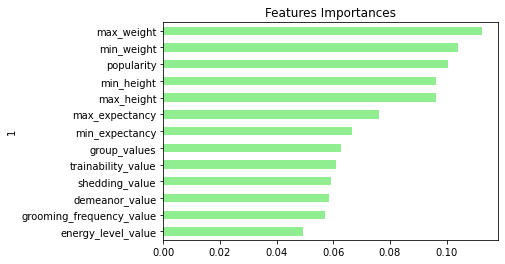

In [80]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [81]:
# Extract the data from the Series and convert it to a numpy array
user_input = []
rand_dog = np.random.randint(0,len(X_test))
user_input = X_test.iloc[rand_dog].values


# # Reshape the user_input to a 2-dimensional array
user_input_reshaped = user_input.reshape(1, -1)

# # Now user_input_reshaped is a 2D array
print('User Input ', user_input)
print('User Input Reshaped ',user_input_reshaped)

print('Random index  ',rand_dog)
print(dog_breed_data_df[['breed','breed_values']].iloc[rand_dog])
print('y test value ',y_test[rand_dog])
print(X_test.iloc[rand_dog])


User Input  [ 0.  15.  20.  25.  40.  12.  15.   0.2  0.6  0.8  0.4  0.4  4. ]
User Input Reshaped  [[ 0.  15.  20.  25.  40.  12.  15.   0.2  0.6  0.8  0.4  0.4  4. ]]
Random index   4712
breed           Bergamasco Sheepdog
breed_values                    187
Name: 4712, dtype: object
y test value  62
popularity                   0.0
min_height                  15.0
max_height                  20.0
min_weight                  25.0
max_weight                  40.0
min_expectancy              12.0
max_expectancy              15.0
grooming_frequency_value     0.2
shedding_value               0.6
energy_level_value           0.8
trainability_value           0.4
demeanor_value               0.4
group_values                 4.0
Name: 27066, dtype: float64


In [82]:
new_predictions = rf_model.predict(user_input_reshaped)
print(new_predictions)


[192]


In [83]:
breed_value_to_find = 122
breed_for_value = dog_breed_data_df.loc[dog_breed_data_df['breed_values'] == breed_value_to_find, 'breed'].iloc[0]

print(f"Breed for breed value 25:", breed_for_value)

Breed for breed value 25: Pudelpointer


In [84]:
print(dog_breed_data_df[['breed','breed_values']].iloc[new_predictions])

                  breed  breed_values
192  Norwegian Elkhound           142


In [85]:
dog_breed_data_df.iloc[rand_dog]

breed                                                        Bergamasco Sheepdog
description                    Beneath the one-of-a-kind coat is a large, mus...
temperament                                   Independent, Sociable, Intelligent
popularity                                                                   187
min_height                                                             22.736464
max_height                                                             23.959823
min_weight                                                             64.901293
max_weight                                                             76.478436
min_expectancy                                                         13.201076
max_expectancy                                                         14.637487
group                                                              Herding Group
grooming_frequency_value                                                     0.2
grooming_frequency_category 

In [86]:
# Save Model Using Pickle

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle

# save the model to disk
filename = 'dog_app_rf_breed_pred.sav'
pickle.dump(rf_model, open(filename, 'wb'))

# some time later...

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_scaled, y_test)
print(result)

1.0
